# Comparison _ANN_ vs _CNN_ For Images Classification

To test the performance of a _simple `Convolutional Neural Network`_ a _Baseline_ model using an Artificial Neural Network without `activation functions` (**only linear layers were used**), was built and used as a benchmark.  

A `multi-class` classification problem using the [Fashion MNIST](https://www.kaggle.com/code/digvijayyadav/fmnist-nn-and-cnn), it's used as a dataset to verify that both models works as expected. 


# The Experiment

The experiment aims to compare the performance of both models measuring the level of accuracy of each model to classify correctly a set of images. From the model's point of view the comparison will be only on the **model's architecture**, so the same metaparameters are used to train both models.  

Moreover, the same workflow will be follow to build, train and test both models. The next figure shows the workflow applied in the construction of each classification model.

![workflow](Static/PYTORCH-WORKFLOW.png)


# Scaffolding

The used of a `standard worflow` allows us to define a set of parameters and functions that help on each step of the building process.

The parameters and functions defined to support the workflow are:
- The number of batches that data is splitted
- The number of `epochs` to fit the model
- The learning rate
- The loss function selected
- The optimizer selected
- Metrics
- The training loop
- The testing loop
- Make predictions


In [1]:
# imports
# import pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

# import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from pathlib import Path
import random

%matplotlib inline

## `Getting Data Ready`

As stated above the [Fashion MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset is used. The dataset is loaded directly from pytorch datasets [repository](https://pytorch.org/vision/main/datasets.html), which is accessed thru `torch.utils.data.Dataset`.


In [2]:
# Loading the data
train_dataset = datasets.FashionMNIST(
        root='Data', # Path where to download the dataset
        train=True, # specifies is the data is a Train dataset or Test dataset
        download=True, # specifies if we want to download the dataset
        transform=ToTensor(), # it allows to apply a transformation (get data ready to be consume by pytorch)
        target_transform=None, # How do we want to transfor the labels/target before loading
)

test_data = datasets.FashionMNIST(
        root='Data',
        train=False,
        download=True,
        transform=ToTensor(),
        target_transform=None,
)

# split the test dataset into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
test_dataset  = Subset(test_data, randidx[:7000]) # Subset for test
validation_dataset = Subset(test_data, randidx[7000:]) # Subset for validation

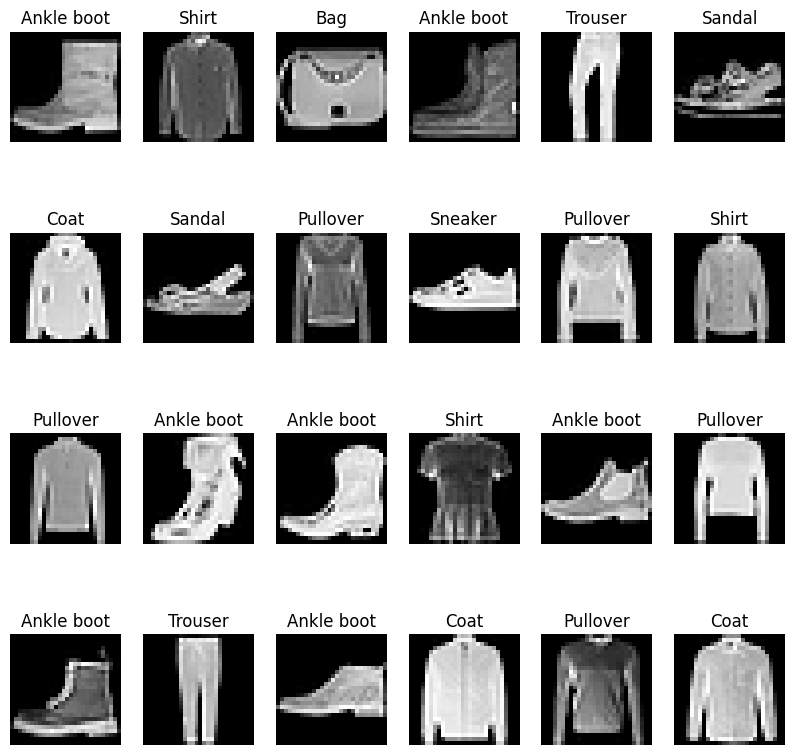

In [3]:
# Visualizing the images
torch.manual_seed(42)

fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 6
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_dataset.classes[label])
    plt.axis(False);
    
plt.show()

In [4]:
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### `In the next sections the support parameters and functions will be defined.`

In [5]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.1

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
def set_loss_optimizer(model: torch.nn.Module, learning_rate: float):
    # Setup loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
    
    return loss_function, optimizer

In [7]:
def get_accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    
    return accuracy

In [8]:
def train_step(model: torch.nn.Module, # Model to be trained
               data_loader: torch.utils.data.DataLoader, # data batches in the form of "Data Loader"
               loss_fn: torch.nn.Module, # Loss Function
               optimizer: torch.optim.Optimizer, # Optimizer
               accuracy_fn, # metric
               device: torch.device = device# Device where execution takes place ("cpu" ; "gpu")
               ):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # NB: Retrieving argmax to go from logits -> pred labels!!!

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
    return train_loss, train_acc

In [9]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # NB: Retrieving argmax to go from logits -> pred labels!!!
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": test_loss.item(),
            "model_accuracy": test_acc}

In [10]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # perform softmax on the "logits" 

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

## `Pytorch DataLoader`

The main purpose of a `DataLoader` is to help load data into a model for training and for inference, turning a **large dataset** into a Python iterable of smaller chunks. Where these smaller chunks are called `batches` or `mini-batches` and can be set by the `batch_size` parameter.

![bacthes](Static/FMNIST-MINI-BATCHES.png)

In [11]:
# Setting the Dataloader ...

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

validation_dataloader = DataLoader(validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the validation data
)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(validation_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 219 batches of 32
Length of validation dataloader: 94 batches of 32


In [12]:
# Check out what's inside the training dataloader (one batch)
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## `Building an Artificial Neural Network Model`

In [13]:
class ANN_Model(nn.Module):
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [14]:
# Getting an instance of the model
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = ANN_Model(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)

model_0

ANN_Model(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
# Setup loss function and optimizer for the model
loss_0, optim_0 = set_loss_optimizer(model_0, LEARNING_RATE)

## `Running the Train Loop for Model 0`

In [16]:
torch.manual_seed(42)
start_train_time = timer()

loss_model0 = []
accuracy_model0 = []

epochs = EPOCHS
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    loss, acc = train_step(data_loader=train_dataloader, 
                           model=model_0, 
                           loss_fn=loss_0,
                           optimizer=optim_0,
                           accuracy_fn=get_accuracy
                          )
    
    loss_model0.append(loss.detach().numpy())
    accuracy_model0.append(acc)
    
    test_step(data_loader=test_dataloader, 
              model=model_0,
              loss_fn=loss_0,
              accuracy_fn=get_accuracy
             )

total_train_time_model_0 = timer() - start_train_time
print(f"Train time on {device}: {total_train_time_model_0:.3f} seconds")

Epoch: 0
---------
Train loss: 0.59039 | Train accuracy: 79.17%
Test loss: 0.51959 | Test accuracy: 81.74%

Epoch: 1
---------
Train loss: 0.47633 | Train accuracy: 83.32%
Test loss: 0.48619 | Test accuracy: 83.24%

Epoch: 2
---------
Train loss: 0.45503 | Train accuracy: 84.05%
Test loss: 0.48347 | Test accuracy: 83.22%

Epoch: 3
---------
Train loss: 0.44251 | Train accuracy: 84.47%
Test loss: 0.46888 | Test accuracy: 83.62%

Epoch: 4
---------
Train loss: 0.43582 | Train accuracy: 84.70%
Test loss: 0.47359 | Test accuracy: 83.15%

Epoch: 5
---------
Train loss: 0.42915 | Train accuracy: 84.97%
Test loss: 0.46631 | Test accuracy: 83.49%

Epoch: 6
---------
Train loss: 0.42475 | Train accuracy: 85.22%
Test loss: 0.49257 | Test accuracy: 83.19%

Epoch: 7
---------
Train loss: 0.42265 | Train accuracy: 85.06%
Test loss: 0.47756 | Test accuracy: 83.36%

Epoch: 8
---------
Train loss: 0.42032 | Train accuracy: 85.25%
Test loss: 0.47249 | Test accuracy: 83.50%

Epoch: 9
---------
Train los

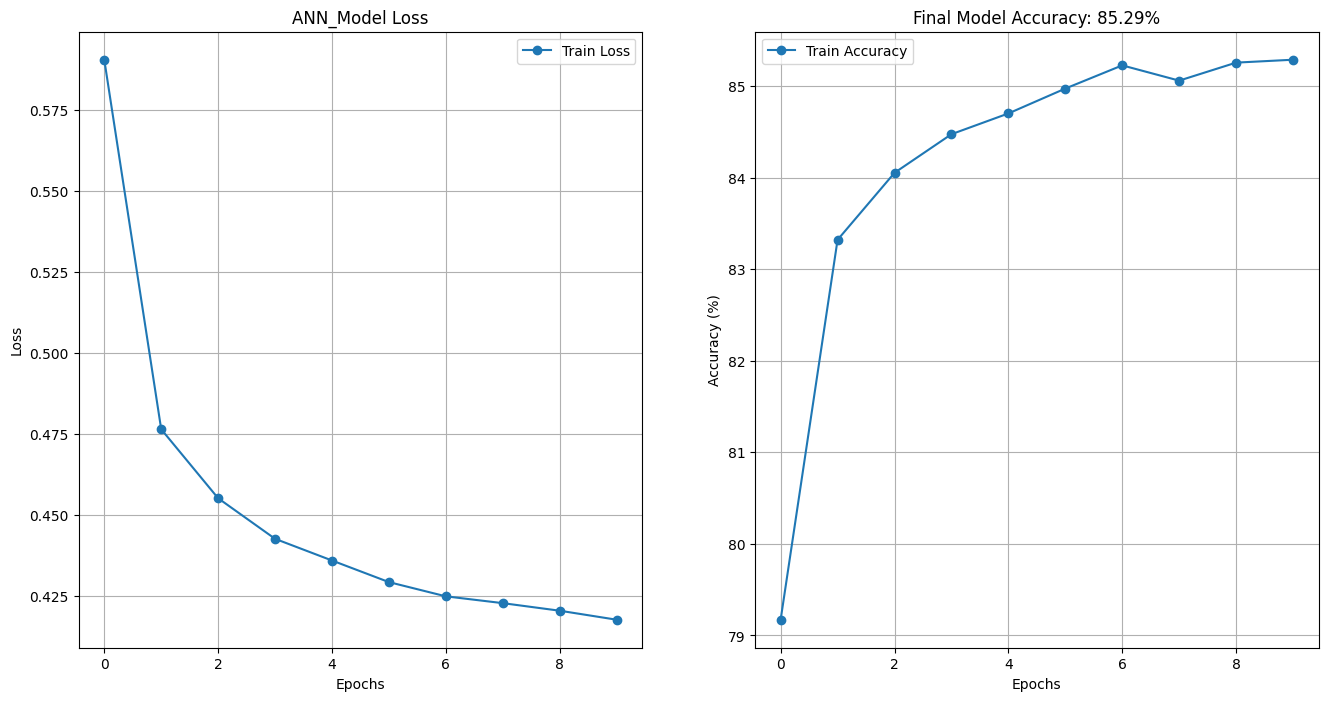

In [18]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(loss_model0,'o-',label='Train Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'{model_0.__class__.__name__} Loss')
ax[0].grid()
ax[0].legend()

ax[1].plot(accuracy_model0,'o-',label='Train Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final Model Accuracy: {accuracy_model0[-1]:.2f}%')
ax[1].grid()
ax[1].legend()

plt.show()

In [19]:
# Calculate model 0 results on validation dataset
model_0_results = test_step(data_loader=validation_dataloader, 
                            model=model_0,
                            loss_fn=loss_0,
                            accuracy_fn=get_accuracy)
model_0_results

Test loss: 0.44652 | Test accuracy: 83.92%



{'model_name': 'ANN_Model',
 'model_loss': 0.44651517271995544,
 'model_accuracy': 83.9206560283688}

## `Save ANN Model`

In [20]:
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "ANN_Linear_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: Models\ANN_Linear_model_0.pth


## `Building a Convolutional Neural Network Model`

The `CNN model` we're going to build is based on the **_TinyVGG_** architecture explained in [CNN Explainer](https://poloclub.github.io/cnn-explainer/) website.

The `TinyVGG` CNN is built using two **convolutional blocks** and a **classification layer**. This architucture will be followed to implement our model for the _FashionMNIST_ classification problem.

![TinyVGG](Static/CNN-TINY-VGG.png)

CNNs utilize a special type of layer, named a `convolutional layer`, that makes them well-positioned to learn from image and image-like data. Regarding image data, CNNs can be used for many different computer vision tasks, such as image processing, classification, segmentation, and object detection.

In [21]:
class CNN_Model(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [22]:
# Getting an instance of the model
torch.manual_seed(42)

# Need to setup model with input parameters
model_2 = CNN_Model(input_shape=1,
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)

model_2

CNN_Model(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [23]:
# Setup loss function and optimizer for the model
loss_2, optim_2 = set_loss_optimizer(model_2, LEARNING_RATE)

## `Running the Train Loop for Model 2`

In [24]:
torch.manual_seed(42)
start_train_time = timer()

loss_model2 = []
accuracy_model2 = []

epochs = EPOCHS
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    loss, acc = train_step(data_loader=train_dataloader, 
                           model=model_2, 
                           loss_fn=loss_2,
                           optimizer=optim_2,
                           accuracy_fn=get_accuracy
                          )
    
    loss_model2.append(loss.detach().numpy())
    accuracy_model2.append(acc)
    
    test_step(data_loader=test_dataloader, 
              model=model_2,
              loss_fn=loss_2,
              accuracy_fn=get_accuracy
             )

total_train_time_model_2 = timer() - start_train_time
print(f"Train time on {device}: {total_train_time_model_2:.3f} seconds")

Epoch: 0
---------
Train loss: 0.58791 | Train accuracy: 78.63%
Test loss: 0.41669 | Test accuracy: 85.32%

Epoch: 1
---------
Train loss: 0.36444 | Train accuracy: 86.77%
Test loss: 0.34534 | Test accuracy: 87.33%

Epoch: 2
---------
Train loss: 0.32567 | Train accuracy: 88.14%
Test loss: 0.32303 | Test accuracy: 88.19%

Epoch: 3
---------
Train loss: 0.30424 | Train accuracy: 89.03%
Test loss: 0.34185 | Test accuracy: 87.25%

Epoch: 4
---------
Train loss: 0.29070 | Train accuracy: 89.51%
Test loss: 0.29553 | Test accuracy: 89.55%

Epoch: 5
---------
Train loss: 0.27869 | Train accuracy: 89.92%
Test loss: 0.30464 | Test accuracy: 89.23%

Epoch: 6
---------
Train loss: 0.27192 | Train accuracy: 90.11%
Test loss: 0.30388 | Test accuracy: 88.88%

Epoch: 7
---------
Train loss: 0.26402 | Train accuracy: 90.44%
Test loss: 0.29294 | Test accuracy: 89.55%

Epoch: 8
---------
Train loss: 0.25526 | Train accuracy: 90.79%
Test loss: 0.29504 | Test accuracy: 89.89%

Epoch: 9
---------
Train los

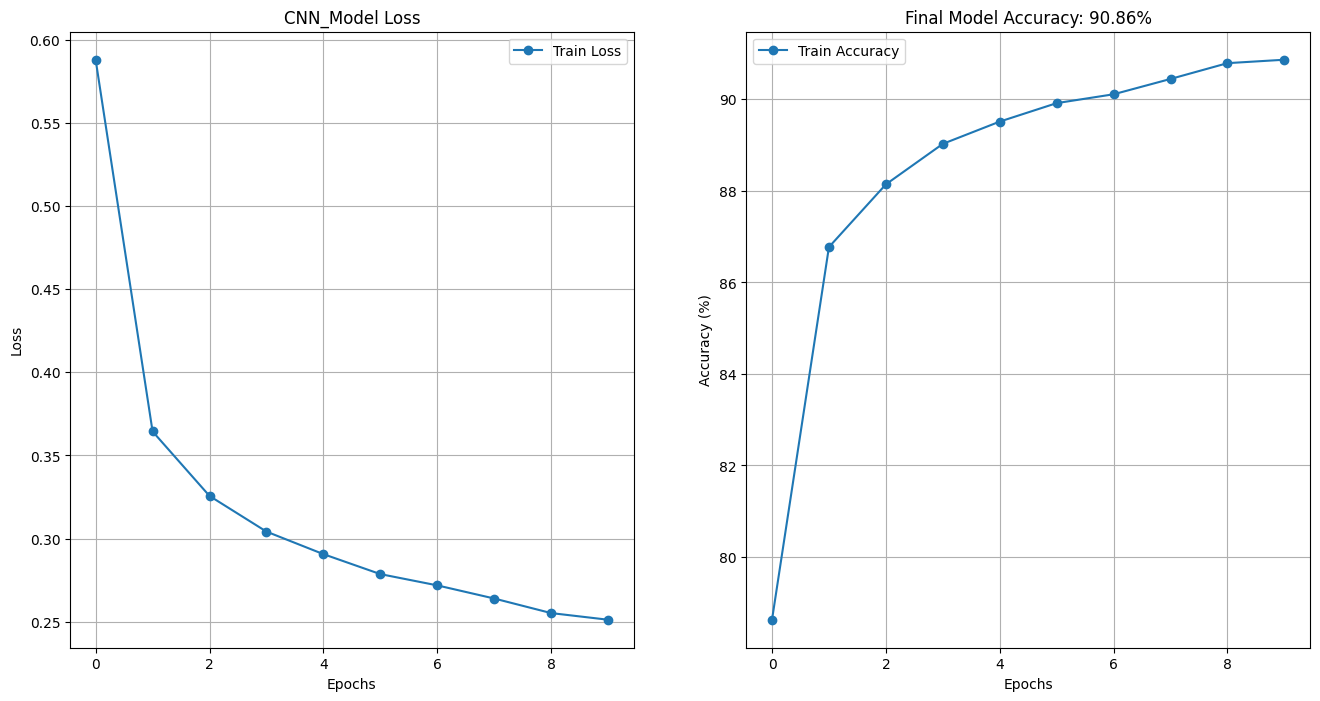

In [25]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(loss_model2,'o-',label='Train Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'{model_2.__class__.__name__} Loss')
ax[0].grid()
ax[0].legend()

ax[1].plot(accuracy_model2,'o-',label='Train Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final Model Accuracy: {accuracy_model2[-1]:.2f}%')
ax[1].grid()
ax[1].legend()

plt.show()

In [26]:
# Calculate model 2 results on validation dataset
model_2_results = test_step(data_loader=validation_dataloader, 
                            model=model_2,
                            loss_fn=loss_2,
                            accuracy_fn=get_accuracy)
model_2_results

Test loss: 0.31132 | Test accuracy: 88.80%



{'model_name': 'CNN_Model',
 'model_loss': 0.3113199472427368,
 'model_accuracy': 88.79654255319149}

## `Save CNN Model`

In [27]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "CNN_TinyVGG_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\CNN_TinyVGG_model_2.pth


## `Comparing Performance of the Models`

In [28]:
compare_results = pd.DataFrame([model_0_results, model_2_results])
# Add number of parameters in each model
total_param_model_0 = sum(p.numel() for p in model_0.parameters())
total_param_model_2 = sum(p.numel() for p in model_2.parameters())
compare_results["model_param"] = [total_param_model_0, total_param_model_2]
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0, total_train_time_model_2]
compare_results

,model_name,model_loss,model_accuracy,model_param,training_time
0,ANN_Model,0.446515,83.920656,7960,280.533844
1,CNN_Model,0.311320,88.796543,7740,839.445202


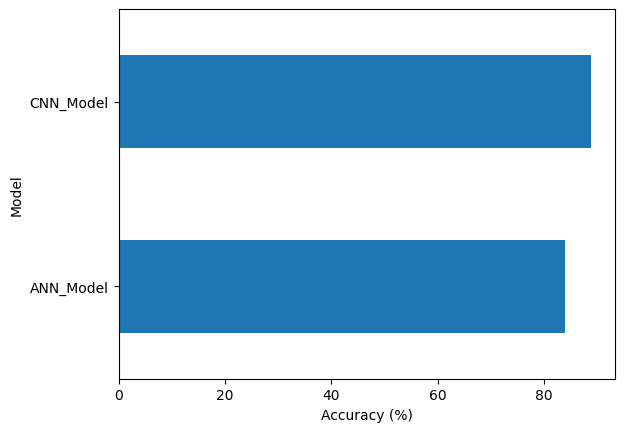

In [29]:
# Visualize model results
compare_results.set_index("model_name")["model_accuracy"].plot(kind="barh")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model");

## `Plotting Images and Its Truth|Predicted Lables`

In [35]:
# Selecting a random sample from the validation dataset
test_samples = []
test_labels = []

for sample, label in random.sample(list(validation_dataset), k=16):
    test_samples.append(sample)
    test_labels.append(label)

In [36]:
# Make predictions on test samples with model 0
pred_probs = make_predictions(model=model_0, data=test_samples)
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

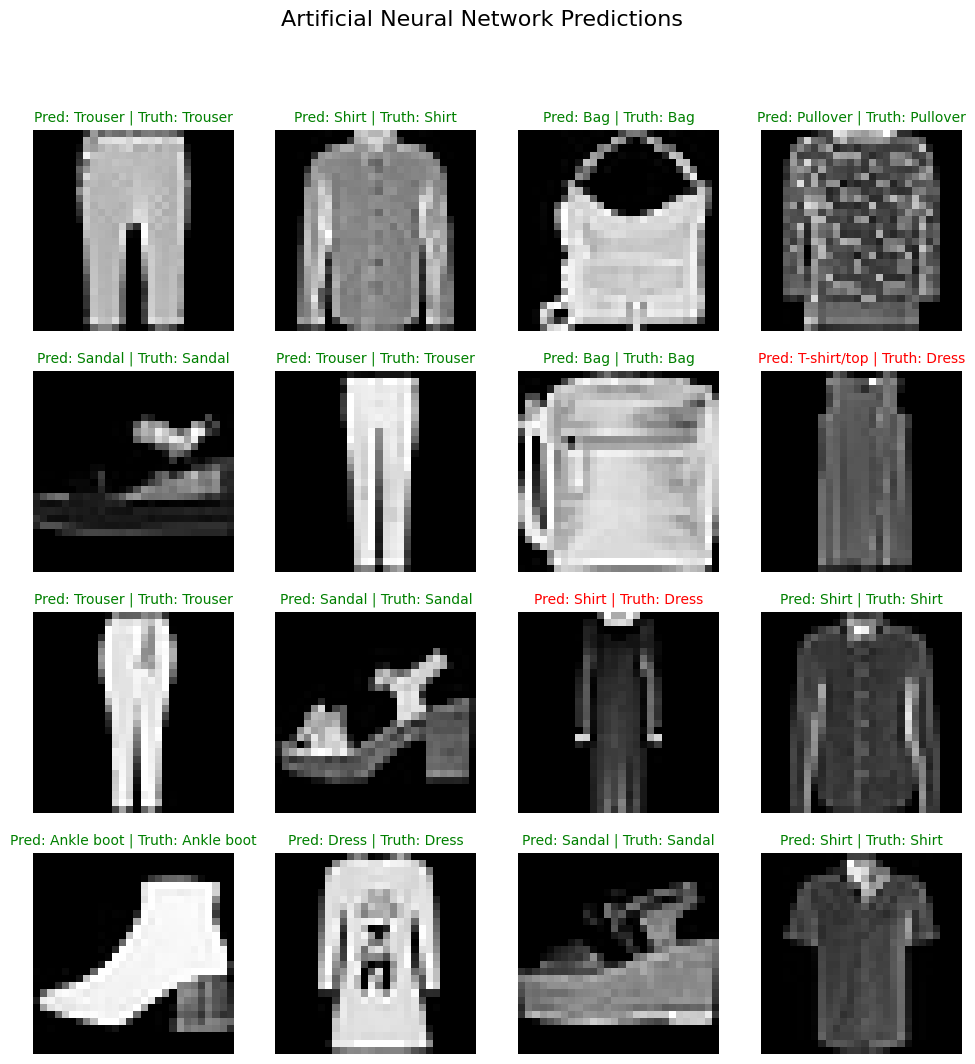

In [37]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 4
ncols = 4

for i, sample in enumerate(test_samples):
    
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong

    plt.axis(False)
    
plt.suptitle('Artificial Neural Network Predictions', fontsize=16)
plt.show()

In [38]:
# Make predictions on test samples with model 2
pred_probs = make_predictions(model=model_2, data=test_samples)
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

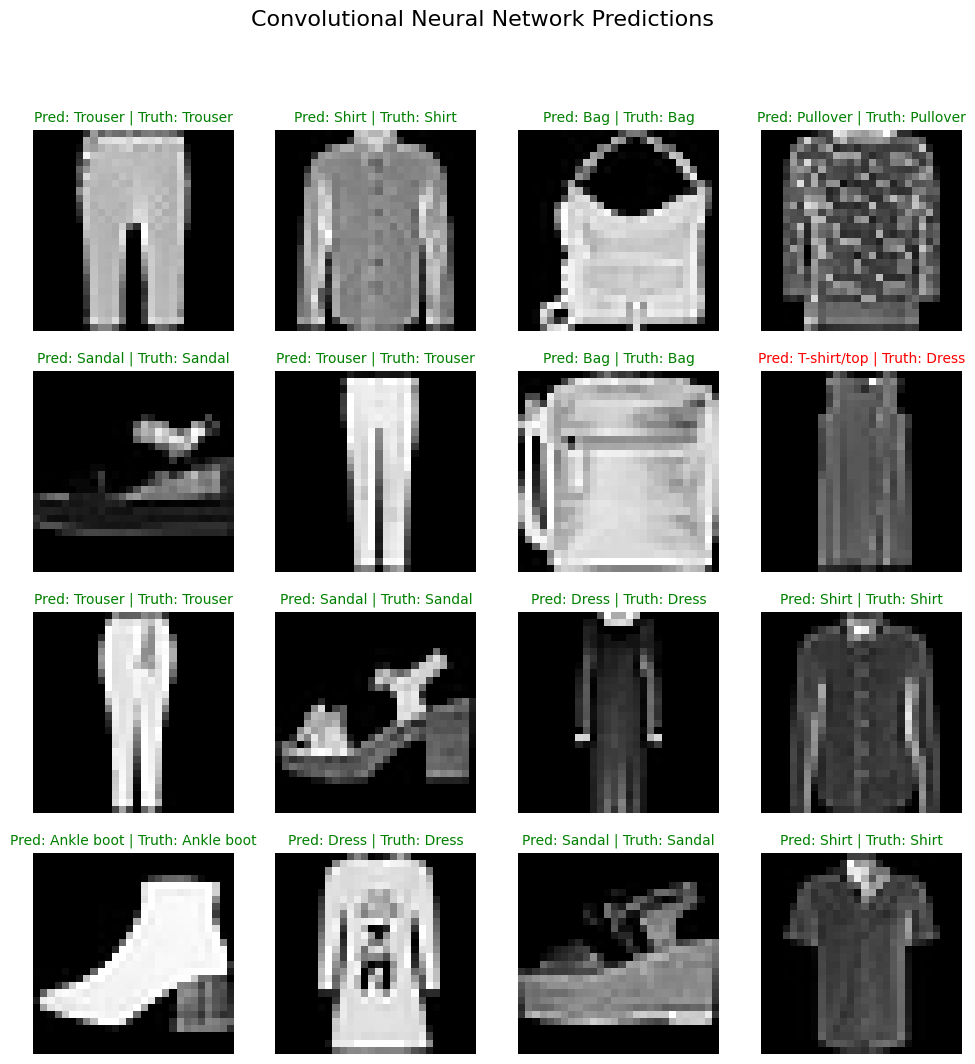

In [39]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 4
ncols = 4

for i, sample in enumerate(test_samples):
    
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong

    plt.axis(False)
    
plt.suptitle('Convolutional Neural Network Predictions', fontsize=16)
plt.show()

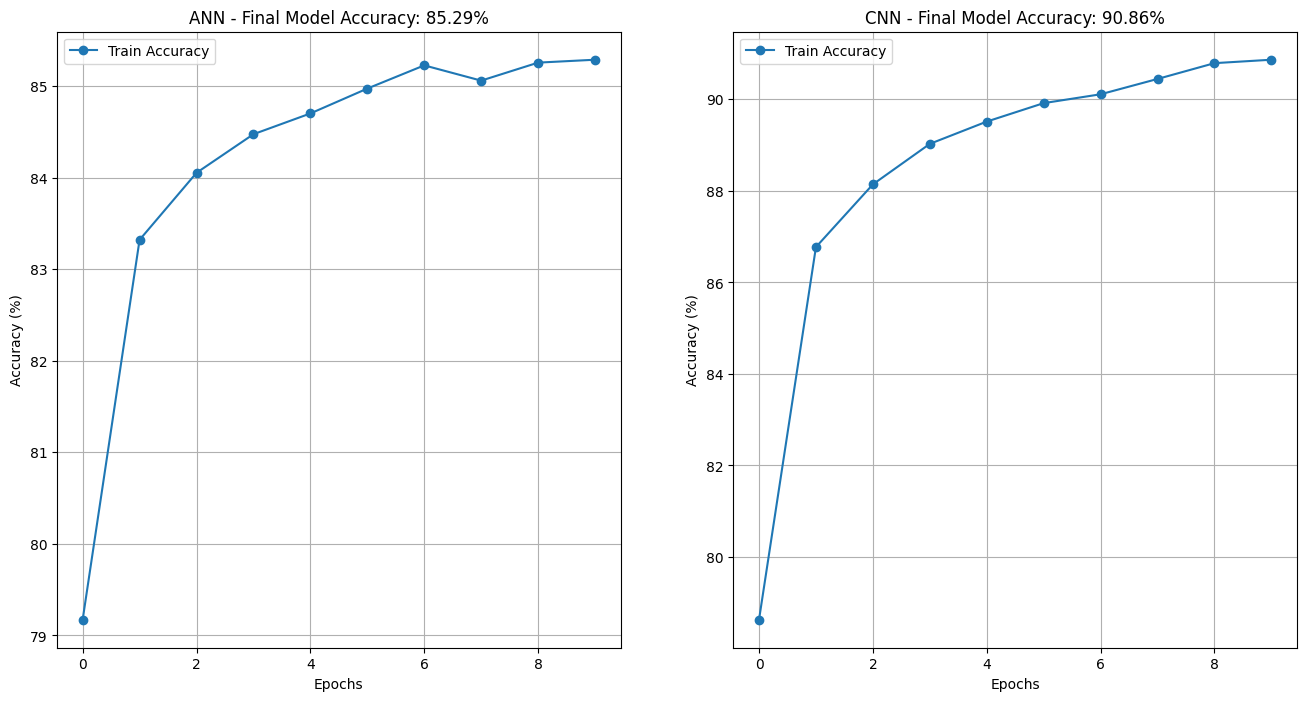

In [40]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(accuracy_model0,'o-',label='Train Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title(f'ANN - Final Model Accuracy: {accuracy_model0[-1]:.2f}%')
ax[0].grid()
ax[0].legend()

ax[1].plot(accuracy_model2,'o-',label='Train Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'CNN - Final Model Accuracy: {accuracy_model2[-1]:.2f}%')
ax[1].grid()
ax[1].legend()

plt.show()